# Import the jena climate dataset from amazon AWS

In [1]:
## import the jena climate dataset from amazon AWS
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip


--2024-04-07 00:48:26--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.45.0, 52.217.86.6, 52.216.184.141, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.45.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

100%[======================================>] 13,565,642  3.74MB/s   in 3.6s   

2024-04-07 00:48:30 (3.59 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Explore the dataset 

In [3]:
# import the dataset
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

# No.of columns
num_variables = len(header)
print("Number of variables:", num_variables)
# No.of rows
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


After inspecting going through the data, we have to convert temperature and rest of the data to 2 different Numpy arrays for later processing or analysis. And we are eliminating date and time from the data


# Cleaning and splitting the dataset

In [4]:
# import the numpy library
import numpy as np

# create a numpy array with name temperature
temperature = np.zeros((len(lines),))

# create a numpy array with name raw data
raw_data = np.zeros((len(lines), len(header) - 1)) 

# Assign values to that arrays
for i, line in enumerate(lines):
 values = [float(x) for x in line.split(",")[1:]]
 temperature[i] = values[1]
 raw_data[i, :] = values[:]

Ploting the temperature with respect to time

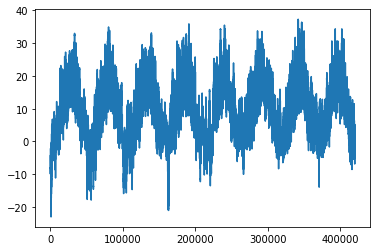

In [5]:
# import the pyplot library
from matplotlib import pyplot as plt

# plot the graph between temperature and time
plt.plot(range(len(temperature)), temperature)

Plotting the temperature with respect to time for 8 days

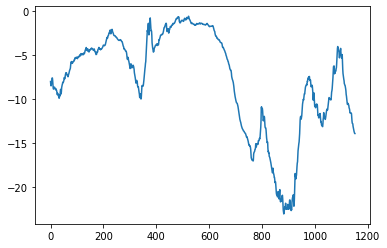

In [6]:
# plot the graph between temperature and time for 7days
plt.plot(range(1152), temperature[:1152])

Computing the number of samples we'll use for each data split

In [5]:
# Assigning the data to each sample
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# print the output sample size
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Prepare the data

Normalise the data

In [6]:
# calculate the mean of the rawdata from training sample
mean = raw_data[:num_train_samples].mean(axis=0)
# calculate the difference of each datapoint from mean
raw_data -= mean

# calculate the standard deviation of the rawdata from training sample
std = raw_data[:num_train_samples].std(axis=0)
# divide each datapoint from standard devaiation
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing

Generating training, validation, and testing datasets—this is necessary due to the large degree of redundancy in the dataset's samples. Therefore, it would be inefficient to explicitly allocate RAM for every sample. Rather, the samples will be produced dynamically.

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Inspecting the output of one of our datasets

In [9]:
# for training
for samples1, targets1 in train_dataset:
    print("samples_train shape:", samples1.shape)
    print("targets_train shape:", targets1.shape)
    break

# for validation
for samples2, targets2 in val_dataset:
    print("samples_validation shape:", samples2.shape)
    print("targets_validation shape:", targets2.shape)
    break

# for test
for samples3, targets3 in test_dataset:
    print("samples_test shape:", samples3.shape)
    print("targets_test shape:", targets3.shape)
    break

samples_train shape: (256, 120, 14)
targets_train shape: (256,)
samples_validation shape: (256, 120, 14)
targets_validation shape: (256,)
samples_test shape: (256, 120, 14)
targets_test shape: (256,)


## A common-sense, non-machine-learning baseline

Computing the common-sense baseline MAE

Calculating the common-sense baseline MAE: The "evaluate_naive_method" defined function offers a starting point for assessing the effectiveness of a basic forecasting technique that uses the final value in the input sequence in order to predict the value that will come after it.

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

for this data, the common sense baseline was
Validation MAE: 2.44
Test MAE: 2.62
which means that an ideal model has the validation and test MAE's as above, A good model has to beat these values which means they have to get less values than these.

## A basic deep-learning model - Dense Layer

Training and evaluating a densely connected model

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# flatten layer
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)

# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

# fit the model
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 25s 29ms/step - loss: 12.2461 - mae: 2.7140 - val_loss: 10.8440 - val_mae: 2.6000
Epoch 2/10
819/819 [==============================] - 22s 27ms/step - loss: 8.8531 - mae: 2.3445 - val_loss: 10.4315 - val_mae: 2.5545
Epoch 3/10
819/819 [==============================] - 25s 30ms/step - loss: 8.1323 - mae: 2.2465 - val_loss: 11.0858 - val_mae: 2.6211
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 7.6723 - mae: 2.1828 - val_loss: 14.2216 - val_mae: 2.9932
Epoch 5/10
819/819 [==============================] - 25s 31ms/step - loss: 7.3904 - mae: 2.1435 - val_loss: 10.8306 - val_mae: 2.5933
Epoch 6/10
819/819 [==============================] - 25s 30ms/step - loss: 7.1596 - mae: 2.1088 - val_loss: 10.9971 - val_mae: 2.6123
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 6.9527 - mae: 2.0772 - val_loss: 10.9602 - val_mae: 2.6170
Epoch 8/10
819/819 [==============================] - 

Evaluate and test the model

In [24]:
# evaluate the model
model = keras.models.load_model("jena_dense.keras")
# Print the tset outputs
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 8s 19ms/step - loss: 11.8387 - mae: 2.6985
Test MAE: 2.70


the validation MAE is 2.746, the test MAE is 2.70, which was greater than comman sense base line. so, we can say that A basic machine-learning model - Dense Layer was not fit to predict the temperature with time

## Plotting the validation and training MAE for each epoch

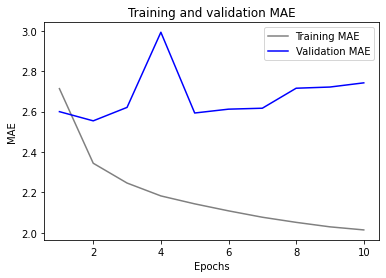

In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## Let's try a 1D convolutional model

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# convolution layer
x = layers.Conv1D(8, 24, activation="relu")(inputs)
# maxpooling layer
x = layers.MaxPooling1D(2)(x)

# convolution layer
x = layers.Conv1D(8, 12, activation="relu")(x)
# maxpooling layer
x = layers.MaxPooling1D(2)(x)

# convolution layer
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

# output layers
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Evaluate the model with test data
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 65ms/step - loss: 21.2505 - mae: 3.5956 - val_loss: 19.7652 - val_mae: 3.5269
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 14.6719 - mae: 3.0451 - val_loss: 19.7611 - val_mae: 3.5566
Epoch 3/10
819/819 [==============================] - 53s 64ms/step - loss: 13.4157 - mae: 2.9050 - val_loss: 17.5024 - val_mae: 3.3046
Epoch 4/10
819/819 [==============================] - 50s 60ms/step - loss: 12.6803 - mae: 2.8195 - val_loss: 14.5913 - val_mae: 3.0022
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 12.1422 - mae: 2.7541 - val_loss: 13.8389 - val_mae: 2.9354
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 11.7176 - mae: 2.7053 - val_loss: 15.8522 - val_mae: 3.1464
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 11.3667 - mae: 2.6658 - val_loss: 16.1690 - val_mae: 3.2086
Epoch 8/10
819/819 [============================

the validation MAE is 3.1378, the test MAE is 3.08, which was greater than comman sense base line. so, we can say that A basic machine-learning model - Dense Layer was not fit to predict the temperature with time

## Plot the validation and training MAE

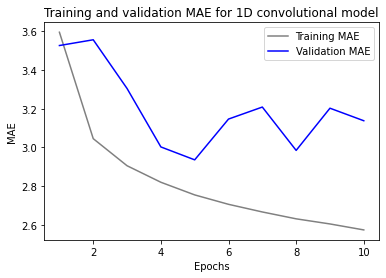

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE for 1D convolutional model")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Convolutional data appear to perform worse than dense models or common sense. It might be due to translation invariance assumption does not hold true for weather data.the sequence in which the data is presented is critical. When it comes to forecasting the temperature for the next day, recent historical data is noticeably more useful than data collected several days before. Unfortunately, this important order of time cannot be captured well by a 1D convolutional neural network.

## Let's use RNN now

## 1.An RNN layer that can process sequences of any length

In [16]:
# no.of features or columns
num_features = 14
steps = 120
# input layer to model
inputs = keras.Input(shape=(None, num_features))
# output layer from model
outputs = layers.SimpleRNN(16)(inputs)

# assign input and output layers to model
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 35s 41ms/step - loss: 138.6856 - mae: 9.6961 - val_loss: 144.0675 - val_mae: 9.9077
Epoch 2/10
819/819 [==============================] - 29s 36ms/step - loss: 136.5384 - mae: 9.5745 - val_loss: 144.0156 - val_mae: 9.9053
Epoch 3/10
819/819 [==============================] - 30s 37ms/step - loss: 136.3997 - mae: 9.5629 - val_loss: 143.7814 - val_mae: 9.8833
Epoch 4/10
819/819 [==============================] - 30s 36ms/step - loss: 136.2810 - mae: 9.5524 - val_loss: 143.6554 - val_mae: 9.8674
Epoch 5/10
819/819 [==============================] - 29s 35ms/step - loss: 136.2263 - mae: 9.5483 - val_loss: 143.6193 - val_mae: 9.8624
Epoch 6/10
819/819 [==============================] - 31s 38ms/step - loss: 136.2033 - mae: 9.5460 - val_loss: 143.6169 - val_mae: 9.8638
Epoch 7/10
819/819 [==============================] - 32s 39ms/step - loss: 136.1722 - mae: 9.5433 - val_loss: 143.5387 - val_mae: 9.8527
Epoch 8/10
819/819 [==============

The Validation and test MAE are 9.84 and 9.92

## 2.RNN with Stacked layers

2 stacked layers with different no.of units in each layer

In [17]:
# no.of features or columns
num_features = 14
steps = 120
# input layer
inputs = keras.Input(shape=(steps, num_features))
# stacked layers
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)

# output layer
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Evaluate the model with test data
model = keras.models.load_model("jena_SRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 70s 83ms/step - loss: 136.8358 - mae: 9.5691 - val_loss: 143.4506 - val_mae: 9.8406
Epoch 2/10
819/819 [==============================] - 67s 82ms/step - loss: 135.9514 - mae: 9.5123 - val_loss: 143.4342 - val_mae: 9.8380
Epoch 3/10
819/819 [==============================] - 64s 78ms/step - loss: 135.9100 - mae: 9.5072 - val_loss: 143.4384 - val_mae: 9.8415
Epoch 4/10
819/819 [==============================] - 67s 82ms/step - loss: 135.8879 - mae: 9.5023 - val_loss: 143.4443 - val_mae: 9.8382
Epoch 5/10
819/819 [==============================] - 64s 78ms/step - loss: 135.8703 - mae: 9.4998 - val_loss: 143.4629 - val_mae: 9.8455
Epoch 6/10
819/819 [==============================] - 66s 80ms/step - loss: 135.8447 - mae: 9.4973 - val_loss: 143.4427 - val_mae: 9.8369
Epoch 7/10
819/819 [==============================] - 66s 80ms/step - loss: 135.8280 - mae: 9.4947 - val_loss: 143.4950 - val_mae: 9.8493
Epoch 8/10
819/819 [==============

3 stacked layers with different no.of units in each layer

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
# no.of features or columns
num_features = 14
steps = 120
# input layer
inputs = keras.Input(shape=(steps, num_features))
# stacked layers
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
x = layers.SimpleRNN(16, return_sequences=True)(x)

# output layer
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN1.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Evaluate the model with test data
model = keras.models.load_model("jena_SRNN1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 91s 108ms/step - loss: 137.0821 - mae: 9.5757 - val_loss: 143.4506 - val_mae: 9.8425
Epoch 2/10
819/819 [==============================] - 80s 97ms/step - loss: 135.9312 - mae: 9.5101 - val_loss: 143.4517 - val_mae: 9.8430
Epoch 3/10
819/819 [==============================] - 76s 93ms/step - loss: 135.8726 - mae: 9.5001 - val_loss: 143.4301 - val_mae: 9.8423
Epoch 4/10
819/819 [==============================] - 74s 90ms/step - loss: 135.8612 - mae: 9.4981 - val_loss: 143.4946 - val_mae: 9.8481
Epoch 5/10
819/819 [==============================] - 73s 89ms/step - loss: 135.8344 - mae: 9.4935 - val_loss: 143.5127 - val_mae: 9.8522
Epoch 6/10
819/819 [==============================] - 81s 98ms/step - loss: 135.8200 - mae: 9.4916 - val_loss: 143.4281 - val_mae: 9.8379
Epoch 7/10
819/819 [==============================] - 76s 93ms/step - loss: 135.8063 - mae: 9.4897 - val_loss: 143.4624 - val_mae: 9.8458
Epoch 8/10
819/819 [=============

2 stacked layers with different no.of units in each layer

In [12]:
# no.of features or columns
num_features = 14
steps = 120
# input layer
inputs = keras.Input(shape=(steps, num_features))
# stacked layers
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)


# output layer
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Evaluate the model with test data
model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 75s 89ms/step - loss: 136.4382 - mae: 9.5464 - val_loss: 143.3812 - val_mae: 9.8302
Epoch 2/10
819/819 [==============================] - 73s 89ms/step - loss: 135.9190 - mae: 9.5083 - val_loss: 143.3964 - val_mae: 9.8329
Epoch 3/10
819/819 [==============================] - 72s 88ms/step - loss: 135.8681 - mae: 9.5015 - val_loss: 143.3629 - val_mae: 9.8295
Epoch 4/10
819/819 [==============================] - 74s 91ms/step - loss: 135.8527 - mae: 9.4995 - val_loss: 143.3502 - val_mae: 9.8262
Epoch 5/10
819/819 [==============================] - 74s 91ms/step - loss: 135.8087 - mae: 9.4925 - val_loss: 143.4719 - val_mae: 9.8461
Epoch 6/10
819/819 [==============================] - 72s 88ms/step - loss: 135.7962 - mae: 9.4904 - val_loss: 143.4072 - val_mae: 9.8366
Epoch 7/10
819/819 [==============================] - 73s 89ms/step - loss: 135.7822 - mae: 9.4881 - val_loss: 143.4031 - val_mae: 9.8374
Epoch 8/10
819/819 [==============

3 stacked layers with different no.of units in each layer

In [13]:
# no.of features or columns
num_features = 14
steps = 120
# input layer
inputs = keras.Input(shape=(steps, num_features))
# stacked layers
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
x = layers.SimpleRNN(32, return_sequences=True)(x)

# output layer
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN3.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Evaluate the model with test data
model = keras.models.load_model("jena_SRNN3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 97s 116ms/step - loss: 136.3719 - mae: 9.5408 - val_loss: 143.4142 - val_mae: 9.8346
Epoch 2/10
819/819 [==============================] - 94s 115ms/step - loss: 135.9033 - mae: 9.5055 - val_loss: 143.3720 - val_mae: 9.8312
Epoch 3/10
819/819 [==============================] - 94s 115ms/step - loss: 135.8321 - mae: 9.4953 - val_loss: 143.4210 - val_mae: 9.8397
Epoch 4/10
819/819 [==============================] - 93s 113ms/step - loss: 135.8001 - mae: 9.4895 - val_loss: 143.4389 - val_mae: 9.8410
Epoch 5/10
819/819 [==============================] - 92s 113ms/step - loss: 135.7785 - mae: 9.4857 - val_loss: 143.4438 - val_mae: 9.8409
Epoch 6/10
819/819 [==============================] - 93s 114ms/step - loss: 135.7640 - mae: 9.4824 - val_loss: 143.4147 - val_mae: 9.8366
Epoch 7/10
819/819 [==============================] - 90s 110ms/step - loss: 135.7630 - mae: 9.4819 - val_loss: 143.4700 - val_mae: 9.8464
Epoch 8/10
819/819 [=======

3 stacked layers with different no.of units in each layer

In [14]:
# no.of features or columns
num_features = 14
steps = 120
# input layer
inputs = keras.Input(shape=(steps, num_features))
# stacked layers
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
x = layers.SimpleRNN(16, return_sequences=True)(x)

# output layer
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN4.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Evaluate the model with test data
model = keras.models.load_model("jena_SRNN4.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 102s 122ms/step - loss: 136.5838 - mae: 9.5464 - val_loss: 143.3850 - val_mae: 9.8354
Epoch 2/10
819/819 [==============================] - 100s 123ms/step - loss: 135.9128 - mae: 9.5066 - val_loss: 143.3907 - val_mae: 9.8341
Epoch 3/10
819/819 [==============================] - 103s 125ms/step - loss: 135.8624 - mae: 9.4992 - val_loss: 143.3676 - val_mae: 9.8271
Epoch 4/10
819/819 [==============================] - 102s 124ms/step - loss: 135.8393 - mae: 9.4953 - val_loss: 143.3795 - val_mae: 9.8317
Epoch 5/10
819/819 [==============================] - 99s 121ms/step - loss: 135.8189 - mae: 9.4916 - val_loss: 143.3848 - val_mae: 9.8309
Epoch 6/10
819/819 [==============================] - 105s 128ms/step - loss: 135.7963 - mae: 9.4882 - val_loss: 143.4123 - val_mae: 9.8342
Epoch 7/10
819/819 [==============================] - 104s 127ms/step - loss: 135.7593 - mae: 9.4824 - val_loss: 143.4227 - val_mae: 9.8353
Epoch 8/10
819/819 [=

## Lets try with GRU layer (gated recurrent Unit)

with one GRU layer

In [15]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# GRU layer
x = layers.GRU(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 62ms/step - loss: 37.9645 - mae: 4.4881 - val_loss: 12.0523 - val_mae: 2.6194
Epoch 2/10
819/819 [==============================] - 48s 59ms/step - loss: 10.6229 - mae: 2.5349 - val_loss: 9.5524 - val_mae: 2.3882
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 9.5524 - mae: 2.4153 - val_loss: 9.2281 - val_mae: 2.3645
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 9.2179 - mae: 2.3716 - val_loss: 9.2592 - val_mae: 2.3645
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 8.9820 - mae: 2.3415 - val_loss: 9.3677 - val_mae: 2.3818
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 8.7768 - mae: 2.3164 - val_loss: 9.4422 - val_mae: 2.3859
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 8.5976 - mae: 2.2940 - val_loss: 9.3761 - val_mae: 2.3854
Epoch 8/10
819/819 [==============================] - 47s 5

Plotting the validation and training MAE

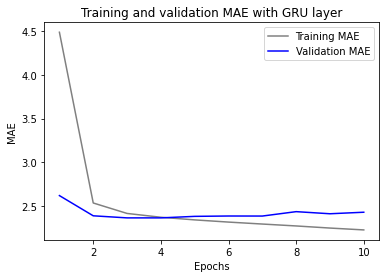

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE with GRU layer")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## lets Replace GRU with LSTM(Long Short-Term Memory)

1. Simple LSTM

In [13]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# lSTM layer
x = layers.LSTM(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# call back
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
# test the model
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 129s 155ms/step - loss: 38.0236 - mae: 4.4790 - val_loss: 11.6924 - val_mae: 2.6081
Epoch 2/10
819/819 [==============================] - 123s 150ms/step - loss: 10.9367 - mae: 2.5684 - val_loss: 9.5955 - val_mae: 2.4169
Epoch 3/10
819/819 [==============================] - 122s 149ms/step - loss: 9.7597 - mae: 2.4335 - val_loss: 9.8462 - val_mae: 2.4403
Epoch 4/10
819/819 [==============================] - 124s 151ms/step - loss: 9.2520 - mae: 2.3709 - val_loss: 9.8506 - val_mae: 2.4341
Epoch 5/10
819/819 [==============================] - 119s 145ms/step - loss: 8.9437 - mae: 2.3320 - val_loss: 9.7099 - val_mae: 2.4111
Epoch 6/10
819/819 [==============================] - 125s 152ms/step - loss: 8.7397 - mae: 2.3057 - val_loss: 9.6698 - val_mae: 2.4087
Epoch 7/10
819/819 [==============================] - 123s 150ms/step - loss: 8.4953 - mae: 2.2768 - val_loss: 9.6275 - val_mae: 2.4068
Epoch 8/10
819/819 [=========================

Plot the output

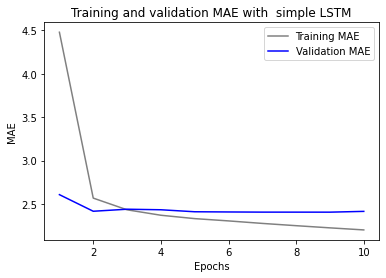

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey",label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",label="Validation MAE")
plt.title("Training and validation MAE with  simple LSTM")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [15]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
# Dropout layer
x = layers.Dropout(0.5)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

# compile the data
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 230s 277ms/step - loss: 47.4824 - mae: 5.1328 - val_loss: 13.6618 - val_mae: 2.7987
Epoch 2/10
819/819 [==============================] - 228s 279ms/step - loss: 19.6630 - mae: 3.4074 - val_loss: 10.1335 - val_mae: 2.4757
Epoch 3/10
819/819 [==============================] - 229s 279ms/step - loss: 18.0553 - mae: 3.2686 - val_loss: 9.8762 - val_mae: 2.4559
Epoch 4/10
819/819 [==============================] - 231s 282ms/step - loss: 17.1600 - mae: 3.1862 - val_loss: 9.4880 - val_mae: 2.4042
Epoch 5/10
819/819 [==============================] - 227s 277ms/step - loss: 16.6730 - mae: 3.1402 - val_loss: 9.4893 - val_mae: 2.4007
Epoch 6/10
819/819 [==============================] - 229s 280ms/step - loss: 16.1839 - mae: 3.1011 - val_loss: 9.4082 - val_mae: 2.3876
Epoch 7/10
819/819 [==============================] - 227s 277ms/step - loss: 15.6768 - mae: 3.0530 - val_loss: 9.4463 - val_mae: 2.3895
Epoch 8/10
819/819 [===================

Plot the output

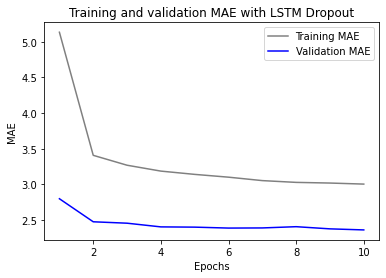

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE with LSTM Dropout")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

3. LSTM - Stacked setup with 2layers

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# stacked layers
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)

# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=4,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/4
819/819 [==============================] - 185s 222ms/step - loss: 41.5955 - mae: 4.7009 - val_loss: 13.2335 - val_mae: 2.7581
Epoch 2/4
819/819 [==============================] - 177s 216ms/step - loss: 10.0802 - mae: 2.4558 - val_loss: 9.8958 - val_mae: 2.4689
Epoch 3/4
819/819 [==============================] - 179s 218ms/step - loss: 8.5468 - mae: 2.2734 - val_loss: 9.8775 - val_mae: 2.4785
Epoch 4/4
405/405 [==============================] - 28s 67ms/step - loss: 11.4648 - mae: 2.6530
Test MAE: 2.65


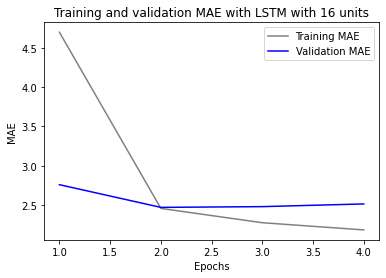

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE with LSTM with 16 units")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

4. LSTM - Stacked setup with 2layers 32units

In [13]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# stacked layers
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)

# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=4,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/4
819/819 [==============================] - 233s 281ms/step - loss: 20.2711 - mae: 3.2434 - val_loss: 9.6701 - val_mae: 2.4312
Epoch 2/4
819/819 [==============================] - 226s 276ms/step - loss: 8.1429 - mae: 2.2278 - val_loss: 10.4883 - val_mae: 2.5213
Epoch 3/4
819/819 [==============================] - 226s 276ms/step - loss: 6.5551 - mae: 1.9954 - val_loss: 11.0085 - val_mae: 2.5900
Epoch 4/4
405/405 [==============================] - 36s 87ms/step - loss: 11.0242 - mae: 2.5874
Test MAE: 2.59


5. LSTM- stacked setup with 2layers 8 units

In [14]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# stacked layers
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)

# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 138s 165ms/step - loss: 72.8065 - mae: 6.5479 - val_loss: 38.9220 - val_mae: 4.6307
Epoch 2/5
819/819 [==============================] - 117s 143ms/step - loss: 22.6015 - mae: 3.5115 - val_loss: 13.7585 - val_mae: 2.7925
Epoch 3/5
819/819 [==============================] - 154s 188ms/step - loss: 11.6403 - mae: 2.6343 - val_loss: 10.0030 - val_mae: 2.4490
Epoch 4/5
819/819 [==============================] - 146s 178ms/step - loss: 10.0363 - mae: 2.4698 - val_loss: 9.5127 - val_mae: 2.3868
Epoch 5/5
405/405 [==============================] - 22s 53ms/step - loss: 10.8050 - mae: 2.5613
Test MAE: 2.56


Plot the output

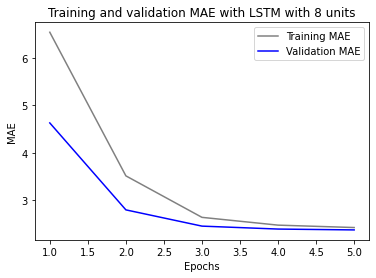

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE with LSTM with 8 units")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

6. LSTM- stacked setup with 3layers 3 different units

In [16]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# stacked layers
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(8, return_sequences=True)(x)
x = layers.LSTM(8)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 231s 277ms/step - loss: 74.8543 - mae: 6.6563 - val_loss: 41.1255 - val_mae: 4.8889
Epoch 2/10
819/819 [==============================] - 224s 274ms/step - loss: 23.5595 - mae: 3.5897 - val_loss: 14.6564 - val_mae: 2.8893
Epoch 3/10
819/819 [==============================] - 200s 244ms/step - loss: 11.1450 - mae: 2.5569 - val_loss: 10.7800 - val_mae: 2.5428
Epoch 4/10
819/819 [==============================] - 218s 266ms/step - loss: 9.1176 - mae: 2.3357 - val_loss: 10.7511 - val_mae: 2.5620
Epoch 5/10
819/819 [==============================] - 207s 252ms/step - loss: 8.3874 - mae: 2.2400 - val_loss: 10.8259 - val_mae: 2.5713
Epoch 6/10
819/819 [==============================] - 187s 228ms/step - loss: 7.8770 - mae: 2.1702 - val_loss: 10.7444 - val_mae: 2.5694
Epoch 7/10
819/819 [==============================] - 202s 247ms/step - loss: 7.5109 - mae: 2.1191 - val_loss: 11.3217 - val_mae: 2.6384
Epoch 8/10
819/819 [==================

Plot the output

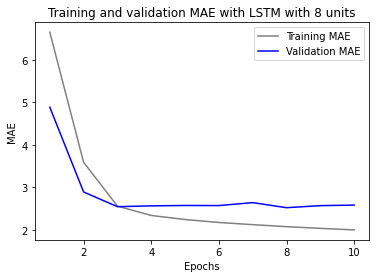

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE with LSTM with 8 units")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

7.LSTM - dropout-regularized, stacked model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 253s 302ms/step - loss: 70.1142 - mae: 6.4284 - val_loss: 34.0781 - val_mae: 4.3631
Epoch 2/5
819/819 [==============================] - 248s 302ms/step - loss: 31.9508 - mae: 4.2485 - val_loss: 14.2159 - val_mae: 2.8378
Epoch 3/5
819/819 [==============================] - 250s 305ms/step - loss: 24.6844 - mae: 3.7668 - val_loss: 11.5415 - val_mae: 2.6130
Epoch 4/5
819/819 [==============================] - 248s 303ms/step - loss: 22.5297 - mae: 3.6058 - val_loss: 10.5050 - val_mae: 2.4984
Epoch 5/5
405/405 [==============================] - 19s 46ms/step - loss: 12.1076 - mae: 2.6912
Test MAE: 2.69


Plot the output

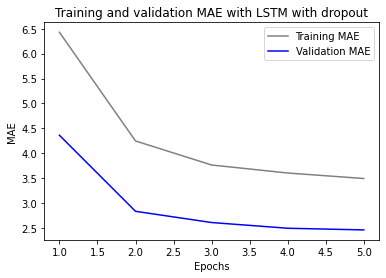

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE with LSTM with dropout")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## Bidirectional LSTM

In [12]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# Bidirectional layer
x = layers.Bidirectional(layers.LSTM(16))(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# call back
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)
# evaluate the model
model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 201s 241ms/step - loss: 29.7010 - mae: 3.8788 - val_loss: 10.9409 - val_mae: 2.5764
Epoch 2/10
819/819 [==============================] - 189s 230ms/step - loss: 9.4962 - mae: 2.4058 - val_loss: 9.8826 - val_mae: 2.4552
Epoch 3/10
819/819 [==============================] - 189s 230ms/step - loss: 8.5732 - mae: 2.2777 - val_loss: 10.0002 - val_mae: 2.4572
Epoch 4/10
819/819 [==============================] - 182s 222ms/step - loss: 8.0064 - mae: 2.2064 - val_loss: 10.1905 - val_mae: 2.4788
Epoch 5/10
819/819 [==============================] - 188s 229ms/step - loss: 7.5822 - mae: 2.1500 - val_loss: 10.7065 - val_mae: 2.5397
Epoch 6/10
819/819 [==============================] - 187s 228ms/step - loss: 7.2158 - mae: 2.1011 - val_loss: 10.7263 - val_mae: 2.5376
Epoch 7/10
819/819 [==============================] - 185s 226ms/step - loss: 6.8785 - mae: 2.0534 - val_loss: 10.8927 - val_mae: 2.5619
Epoch 8/10
819/819 [=====================

Retraining the model with less no.of epochs as there was overfitting

In [13]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# Bidirectional layer
x = layers.Bidirectional(layers.LSTM(16))(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# call back
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM1.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                     callbacks=callbacks)
# evaluate the model
model = keras.models.load_model("jena_bidirec_LSTM1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 192s 231ms/step - loss: 23.4429 - mae: 3.5052 - val_loss: 10.6355 - val_mae: 2.5229
Epoch 2/2
405/405 [==============================] - 30s 72ms/step - loss: 10.1815 - mae: 2.5189
Test MAE: 2.52


## 1D Convnets and LSTM togther

In [14]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# 1D convnets
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D

# LSTM layer
x = layers.LSTM(8)(x)

# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

# fit the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 165s 198ms/step - loss: 76.7789 - mae: 6.7886 - val_loss: 51.0747 - val_mae: 5.5287
Epoch 2/5
819/819 [==============================] - 158s 193ms/step - loss: 32.8017 - mae: 4.2531 - val_loss: 27.3060 - val_mae: 4.1107
Epoch 3/5
819/819 [==============================] - 156s 190ms/step - loss: 18.1235 - mae: 3.2347 - val_loss: 22.6392 - val_mae: 3.7698
Epoch 4/5
819/819 [==============================] - 155s 190ms/step - loss: 14.6979 - mae: 2.9402 - val_loss: 21.8308 - val_mae: 3.6854
Epoch 5/5
405/405 [==============================] - 26s 64ms/step - loss: 24.7280 - mae: 3.9280
Test MAE: 3.93


Plot the model

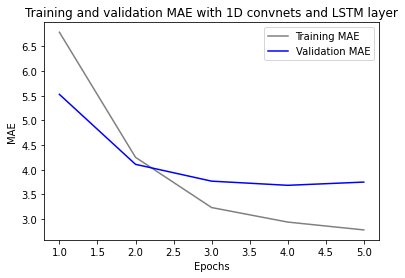

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE with 1D convnets and LSTM layer")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# 1D convnets
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D

# LSTM layer
x = layers.LSTM(16)(x)

# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM1.keras", save_best_only=True)
]

# fit the model
history = model.fit(train_dataset, epochs=6, validation_data=val_dataset, callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_Conv_LSTM1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/6
819/819 [==============================] - 84s 100ms/step - loss: 42.1998 - mae: 4.8514 - val_loss: 23.8101 - val_mae: 3.8165
Epoch 2/6
819/819 [==============================] - 81s 99ms/step - loss: 16.9793 - mae: 3.1858 - val_loss: 23.0851 - val_mae: 3.7840
Epoch 3/6
819/819 [==============================] - 80s 98ms/step - loss: 13.9946 - mae: 2.9006 - val_loss: 23.9421 - val_mae: 3.9438
Epoch 4/6
819/819 [==============================] - 80s 97ms/step - loss: 12.4282 - mae: 2.7240 - val_loss: 27.3609 - val_mae: 4.2729
Epoch 5/6
819/819 [==============================] - 78s 95ms/step - loss: 11.2823 - mae: 2.5912 - val_loss: 27.1567 - val_mae: 4.2016
Epoch 6/6
405/405 [==============================] - 13s 31ms/step - loss: 24.7602 - mae: 3.9336
Test MAE: 3.93


19 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic deep learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - 2 Stacked RNN layers - 16units

Model 6: Simple RNN - 3 Stacked RNN layers - 16units

Model 7: Simple RNN - 2 Stacked RNN layers - 32units

Model 8: Simple RNN - 3 Stacked RNN layers - 32units

Model 9: Simple RNN - 3 Stacked RNN layers -64, 32, 16units

Model 10: A Simple GRU (Gated Recurrent Unit)

Model 11: A simple LSTM (Long-short term memory)

Model 12: LSTM - dropout Regularization

Model 13: LSTM with 2Stacked setup with 16 units

Model 14: LSTM with  2Stacked setup with 32 units

Model 15: LSTM with  2stacked setup with 8 units

Model 16: LSTM with  3Stacked setup with 16,8,8 units

Model 17: LSTM - dropout-regularized, 3stacked

Model 18: Bidirectional LSTM

Model 19: 1D Convnets and LSTM togther

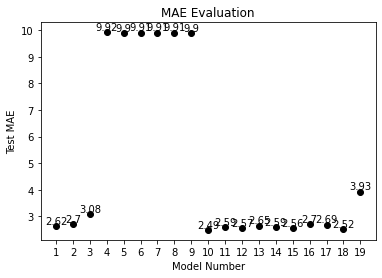

In [5]:
Models = ("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19")
test_MAE = (2.62,2.70,3.08,9.92,9.90,9.91,9.91,9.91,9.90,2.49,2.59,2.57,2.65,2.59,2.56,2.70,2.69,2.52,3.93)

# MAE Evaluation
plt.scatter(Models, test_MAE, color="black")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("Test MAE")

for (xi, yi) in zip(Models,test_MAE):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()